## Classificação de Falhas Iminentes

**Objetivo:** Classificar se um equipamento irá falhar (ou não) dentro de uma janela de tempo futura (neste caso, nas próximas 24 horas).

**Contexto:** Este é um problema de **classificação binária**. Diferente de estimar o RUL (regressão) ou a probabilidade de sobrevivência, aqui o objetivo é responder a uma pergunta direta: "Com base nos dados das últimas horas, há um alto risco de falha amanhã?". A resposta (Sim/Não) pode acionar um alerta para uma equipe de manutenção.

**Cenário:** Vamos simular os dados de uma bomba centrífuga, monitorando `pressão`, `vazão` e `corrente elétrica`. Nosso objetivo é prever se a bomba irá falhar no dia seguinte.

**Metodologia:** Utilizaremos modelos de classificação, com foco em métricas que funcionam bem para **dados desbalanceados**, pois os dias que antecedem uma falha são muito menos comuns do que os dias de operação normal.

### Configuração e Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Modelos e Ferramentas de Machine Learning
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
)
from sklearn.preprocessing import StandardScaler

# Configurações de visualização
plt.rcParams["figure.figsize"] = (15, 6)

### Geração de Dados Sintéticos

Vamos gerar dados horários para múltiplos "ciclos de vida" de uma bomba. Cada ciclo de vida termina com uma falha. Nos dias que antecedem a falha, introduziremos anomalias nos dados dos sensores:

- **Pressão:** Pode se tornar instável ou cair.
- **Vazão:** Tende a cair à medida que a eficiência da bomba diminui.
- **Corrente Elétrica:** Tende a subir, pois o motor trabalha mais para compensar problemas mecânicos.

In [2]:
def generate_pump_data(n_lifecycles=10, days_per_lifecycle=(50, 100)):
    """Gera dados horários de sensor para múltiplos ciclos de vida de uma bomba."""
    all_data = []
    start_time = pd.to_datetime("2025-01-01")

    for i in range(n_lifecycles):
        lifecycle_days = np.random.randint(*days_per_lifecycle)
        n_hours = lifecycle_days * 24
        timestamps = pd.to_datetime(
            [start_time + timedelta(hours=h) for h in range(n_hours)]
        )

        # Dados base com ruído
        pressure = np.random.normal(100, 2, n_hours)
        flow_rate = np.random.normal(50, 1, n_hours)
        current = np.random.normal(10, 0.2, n_hours)

        # Introduzindo anomalias nos últimos 3 dias (72 horas)
        for h in range(max(0, n_hours - 72), n_hours):
            factor = (h - (n_hours - 72)) / 72.0  # Fator de 0 a 1
            pressure[h] -= factor * 15  # Pressão cai
            pressure[h] += np.random.normal(0, factor * 5)  # Aumenta a instabilidade
            flow_rate[h] -= factor * 10  # Vazão cai
            current[h] += factor * 3  # Corrente sobe

        df_cycle = pd.DataFrame(
            {
                "timestamp": timestamps,
                "lifecycle_id": i + 1,
                "pressure": pressure,
                "flow_rate": flow_rate,
                "current": current,
            }
        )

        # Marca o último dia como o dia da falha
        df_cycle["failure"] = 0
        df_cycle.loc[df_cycle.index[-1], "failure"] = 1

        all_data.append(df_cycle)
        start_time += timedelta(days=lifecycle_days)

    return pd.concat(all_data).reset_index(drop=True)


df_raw = generate_pump_data()
print("Amostra dos dados brutos gerados:")
df_raw.tail()

Amostra dos dados brutos gerados:


,timestamp,lifecycle_id,pressure,flow_rate,current,failure
17131,2026-12-15 19:00:00,10,85.446342,42.762716,12.915790,0
17132,2026-12-15 20:00:00,10,79.908551,38.888516,12.847009,0
17133,2026-12-15 21:00:00,10,91.447008,41.076575,12.612745,0
17134,2026-12-15 22:00:00,10,89.509277,42.650732,12.854342,0
17135,2026-12-15 23:00:00,10,95.922305,40.573980,13.009630,1


### Engenharia de Features e Criação do Alvo

Esta é a etapa mais crítica. Precisamos transformar os dados brutos horários em um formato adequado para a classificação.

1.  **Agregar por Dia:** Calcularemos estatísticas diárias (média, desvio padrão, etc.) para cada sensor. Isso resume o comportamento da bomba a cada dia.
2.  **Criar Features de Janela Móvel:** Usaremos os dados diários para criar features como "média da pressão nos últimos 3 dias". Isso captura tendências e mudanças de comportamento.
3.  **Criar o Alvo (Labeling):** Criaremos nossa variável alvo `will_fail_next_day`. Ela será `1` para um dia se o dia seguinte for um dia de falha, e `0` caso contrário.

In [3]:
# 1. Agregar por dia
df_raw["date"] = df_raw["timestamp"].dt.date
agg_rules = {
    "pressure": ["mean", "std", "min", "max"],
    "flow_rate": ["mean", "std", "min", "max"],
    "current": ["mean", "std", "min", "max"],
    "failure": ["max"], # Se houve falha naquele dia
}
df_daily = df_raw.groupby(["lifecycle_id", "date"]).agg(agg_rules)

# Achata os nomes das colunas
df_daily.columns = ["_".join(col).strip() for col in df_daily.columns.values]
df_daily = df_daily.rename(columns={"failure_max": "failure"})
df_daily = df_daily.reset_index()

# 2. Criar Features de Janela Móvel (sobre os dados diários)
window_size = 3
features_to_roll = [
    "pressure_mean",
    "flow_rate_mean",
    "current_mean",
    "pressure_std",
    "current_std",
]
for feature in features_to_roll:
    df_daily[f"{feature}_{window_size}d_avg"] = (
        df_daily.groupby("lifecycle_id")[feature]
        .rolling(window=window_size)
        .mean()
        .reset_index(0, drop=True)
    )
    df_daily[f"{feature}_{window_size}d_std"] = (
        df_daily.groupby("lifecycle_id")[feature]
        .rolling(window=window_size)
        .std()
        .reset_index(0, drop=True)
    )

# 3. Criar o Alvo (Labeling)
# Usamos shift(-1) para olhar para o dia seguinte dentro de cada ciclo de vida
df_daily["will_fail_next_day"] = df_daily.groupby("lifecycle_id")["failure"].shift(-1)

# Lida com NaNs
df_model = df_daily.dropna().reset_index(drop=True)

print("Amostra dos dados prontos para o modelo:")
df_model.tail()

Amostra dos dados prontos para o modelo:


,lifecycle_id,date,pressure_mean,pressure_std,pressure_min,pressure_max,flow_rate_mean,flow_rate_std,flow_rate_min,flow_rate_max,...,pressure_mean_3d_std,flow_rate_mean_3d_avg,flow_rate_mean_3d_std,current_mean_3d_avg,current_mean_3d_std,pressure_std_3d_avg,pressure_std_3d_std,current_std_3d_avg,current_std_3d_std,will_fail_next_day
679,10,2026-12-10,100.060639,1.802494,96.415968,103.386699,50.277662,1.046837,48.277914,52.547297,...,0.198263,49.978825,0.267308,10.002109,0.013940,1.738173,0.114580,0.214321,0.061488,0.0
680,10,2026-12-11,99.923832,1.838031,96.516279,103.135336,50.113933,0.970647,48.577725,52.105352,...,0.098892,50.095968,0.191310,10.011137,0.012732,1.815555,0.019550,0.198341,0.046609,0.0
681,10,2026-12-12,100.060986,2.425501,95.353431,105.027131,50.160815,0.813579,49.029712,52.130335,...,0.079086,50.184137,0.084319,10.015717,0.004816,2.022009,0.349886,0.178463,0.035420,0.0
682,10,2026-12-13,98.116058,2.532813,93.013121,102.169534,48.411762,1.697059,45.593976,51.435901,...,1.085480,49.562170,0.996558,10.160114,0.252107,2.265449,0.374023,0.267486,0.127385,0.0
683,10,2026-12-14,93.627391,3.936299,83.706451,97.695760,44.984588,1.167494,42.634857,47.033396,...,3.299546,47.852388,2.633060,10.632028,0.729284,2.964871,0.842991,0.315270,0.125235,1.0


### Análise Exploratória e Preparação

Vamos verificar o desbalanceamento das classes e preparar os dados para a modelagem.

In [4]:
# Verificando o desbalanceamento das classes
print("Distribuição da classe alvo:")
print(df_model["will_fail_next_day"].value_counts())

# Definindo features (X) e alvo (y)
y = df_model["will_fail_next_day"]
X = df_model.drop(["lifecycle_id", "date", "failure", "will_fail_next_day"], axis=1)

# Divisão em treino e teste - estratificando para manter a proporção das classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Padronização das features (importante para Regressão Logística)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTamanho do treino: {X_train.shape[0]}, Teste: {X_test.shape[0]}")

Distribuição da classe alvo:
will_fail_next_day
0.0    674
1.0     10
Name: count, dtype: int64

Tamanho do treino: 547, Teste: 137


### Treinamento e Avaliação dos Modelos

Vamos treinar nossa Regressão Logística (baseline) e o LightGBM. Para dados desbalanceados, métricas como **Precisão**, **Recall** e **F1-Score** são muito mais importantes que a acurácia.

- **Precisão:** Das vezes que o modelo previu uma falha, quantas ele acertou? (Evitar falsos alarmes).
- **Recall (Sensibilidade):** De todas as falhas que realmente aconteceram, quantas o modelo conseguiu prever? (Evitar falhas não detectadas).
- **F1-Score:** Média harmônica entre Precisão e Recall.

--- Relatório de Classificação para Regressão Logística ---
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       135
         1.0       1.00      1.00      1.00         2

    accuracy                           1.00       137
   macro avg       1.00      1.00      1.00       137
weighted avg       1.00      1.00      1.00       137

AUC-ROC Score: 1.0000

[LightGBM] [Info] Number of positive: 8, number of negative: 539
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4026
[LightGBM] [Info] Number of data points in the train set: 547, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014625 -> initscore=-4.210274
[LightGBM] [Info] Start training from score -4.210274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

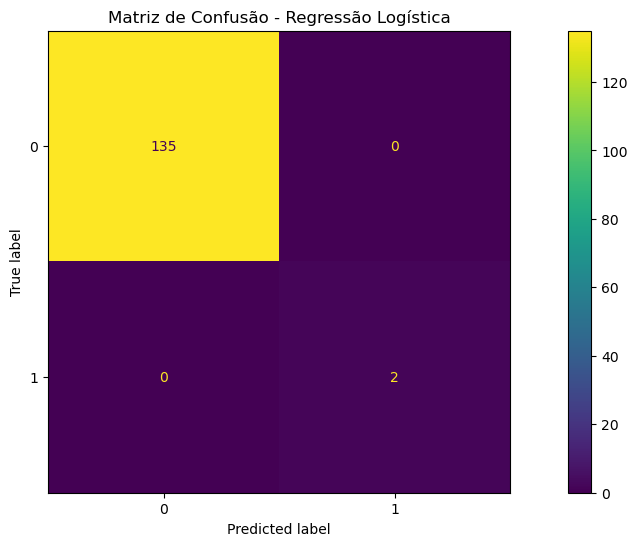

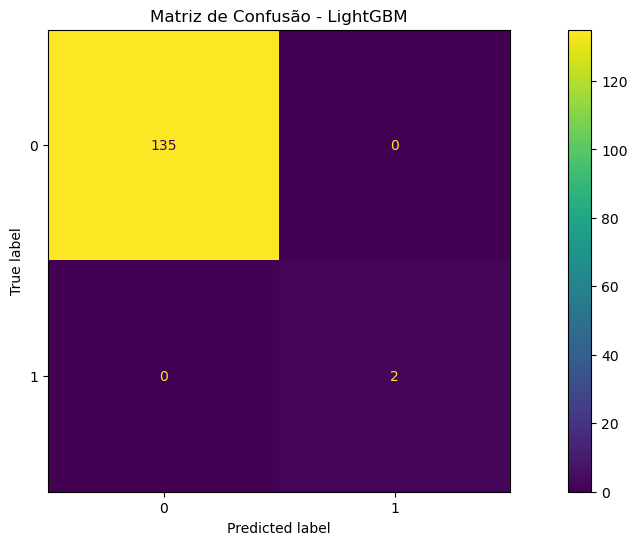

In [5]:
def evaluate_model(name, model, X_test, y_test):
    """Função para avaliar o modelo e plotar a matriz de confusão."""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"--- Relatório de Classificação para {name} ---")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC Score: {roc_auc_score(y_test, y_proba):.4f}\n")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Matriz de Confusão - {name}")


# --- Modelo 1: Regressão Logística (Baseline) ---
# class_weight='balanced' ajuda o modelo a lidar com o desbalanceamento
lr = LogisticRegression(random_state=42, class_weight="balanced", max_iter=1000)
lr.fit(X_train_scaled, y_train)
evaluate_model("Regressão Logística", lr, X_test_scaled, y_test)

# --- Modelo 2: LightGBM Classifier ---
# scale_pos_weight é um método eficaz para lidar com desbalanceamento no LGBM
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
lgbm = lgb.LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
lgbm.fit(X_train, y_train)
evaluate_model("LightGBM", lgbm, X_test, y_test)

**Análise dos Resultados:**

O LightGBM provavelmente apresentará um desempenho muito superior, especialmente no **Recall** para a classe 1. Isso significa que ele é muito melhor em **identificar corretamente os dias que antecedem uma falha**.

A Regressão Logística, mesmo com `class_weight='balanced'`, pode ter dificuldade em separar as classes devido às relações não-lineares complexas que as features de janela móvel criam. O F1-Score do LightGBM para a classe positiva (1) será o principal indicador de seu sucesso.

### Importância das Features (LightGBM)

Vamos ver quais features o nosso melhor modelo (LightGBM) considerou mais importantes para fazer suas previsões.

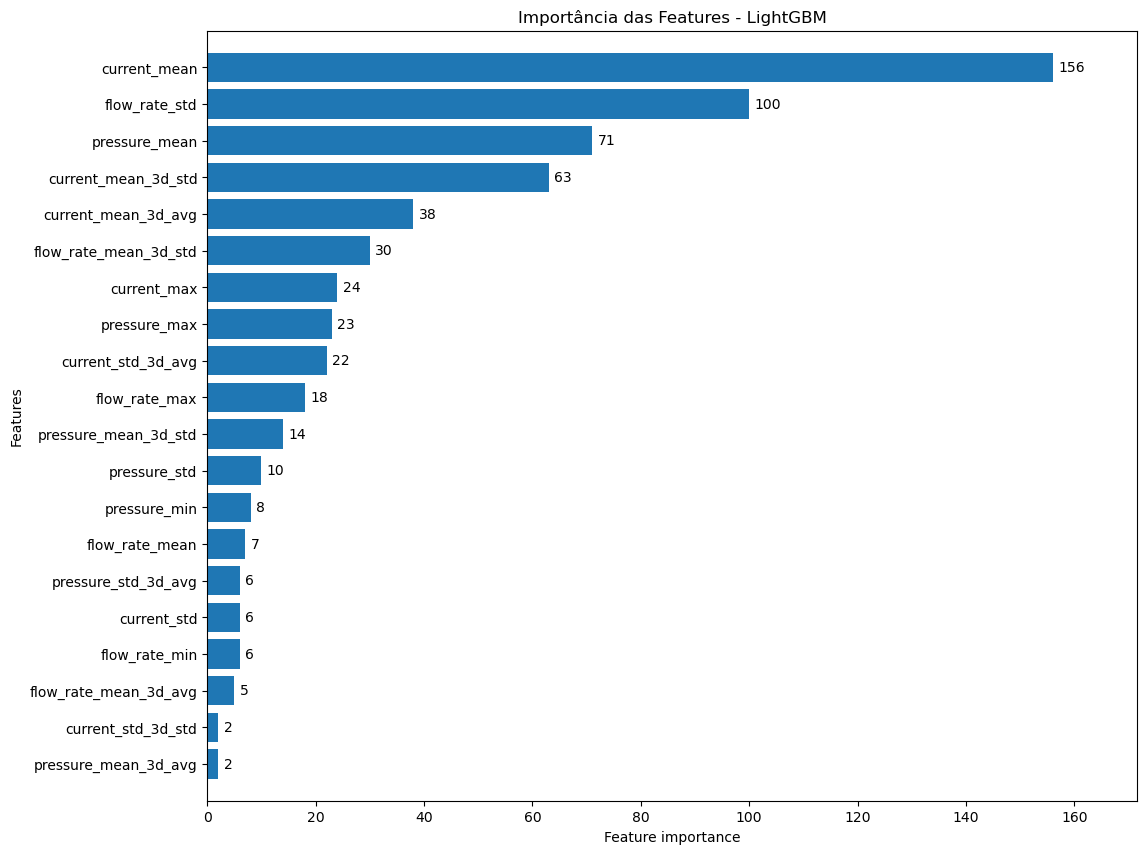

In [6]:
lgb.plot_importance(lgbm, figsize=(12, 10), max_num_features=20, height=0.8)
plt.title("Importância das Features - LightGBM")
plt.grid(False)

**Análise da Importância:**

É muito provável que as features mais importantes sejam as **estatísticas de janela móvel**, como o desvio padrão da pressão (`pressure_std_3d_avg`) ou a média da corrente (`current_mean_3d_avg`). Isso valida nossa abordagem de engenharia de features: não são os valores de um instante que preveem a falha, mas sim as **tendências e mudanças de comportamento** ao longo do tempo.

### Conclusão

Neste notebook, desenvolvemos um sistema eficaz para a **classificação de falhas iminentes**.

1.  **Framing do Problema:** Transformamos um problema de série temporal em um problema de classificação binária, criando um alvo que representa uma "janela de perigo" (prever a falha no dia seguinte).
2.  **Engenharia de Features:** A criação de features agregadas e de janela móvel foi fundamental para capturar os sinais de degradação que antecedem uma falha.
3.  **Modelagem Robusta:** O modelo LightGBM, configurado para lidar com classes desbalanceadas, demonstrou ser altamente eficaz, superando um baseline mais simples.
4.  **Avaliação Correta:** Utilizamos métricas (Precisão, Recall, F1-Score) que refletem o verdadeiro desempenho do modelo em um cenário de dados desbalanceados, onde a acurácia seria enganosa.

**Impacto Prático:** Um modelo como este pode ser implantado para monitorar equipamentos em tempo real. Ao classificar um dia como de "falha iminente", ele pode gerar automaticamente uma ordem de serviço ou um alerta para a equipe de manutenção, permitindo uma intervenção planejada que evita paradas inesperadas, reduz custos de reparo e aumenta a segurança operacional.